# Bridging the Food Gap: Identifying Emergency Food Supply Risks using Logistic Regression
Emily Nguyen, Ira Samant, Darren Summerlee, Greg Opie, Sabrin Kulatein

## Introduction
---
Food insecurity is a problem that citizens all around the United States face, particularly during emergencies when access to essential resources become scarce. In large cities like New York City, emergency food supply funds can play a huge role in helping individuals that need it most. However, disparities in distribution of available food resources create substantial food challenges in particular targeted areas.

This research analyzes emergency food supply gap data that NYC Open Data made available for different Neighborhood Tabulation Areas (NTAs) throughout the city, which consists of 9 variables that track unmet food needs and demographics. The analyzed data contains information about food supply gaps in pounds, along with other significant variables such as food insecurity percentage, unemployment rate, and vulnerable population percentage including non-citizen immigrants, elderly citizens, and children. Considering the dataset, we have chosen our target variable to be the supply gap to determine what is the strongest influence on disparities in emergency food distribution. These indicators measure the emergency food need as well as social-economic aspects within each neighborhood for effective analysis. 

Our goal is to build a regression model that analyzes how population characters and economic indicators determine the unsatisfied food demand across NY neighborhoods. We want to identify how vulnerable populations are disproportionately affected when emergency food resources are poorly distributed or unavailable. This project will cover the production of a regression model that uses the Emergency Food Supply Gap dataset to identify the factors that correlate with the largest food supply gaps. This project will walk through the process of data cleaning, exploratory data analysis, visualization, and model development to extract practical insights. 

## Data Description
---
The dataset used in this analysis contains **589** samples, each row representing a Neighborhood Tabulation Area (NTA) in New York City for a given analysis year (2022 - 2024). There are **9 columns** in total, including one target variable and several demographic and socioeconomic variables that may help explain the disparities in food distribution during emergencies. 
Here is a brief description of each variable: 
- **year**: The reporting year of the data (numeric)
- **nta**: A unique code representing each Neighborhood Tabulation Area (text)
- **nta_name**: The name of the NYC neighborhood (text)
- **supply_gap_lbs**: The difference between the estimated pounds of emergency food needed and the pounds actually supplied (numeric)
- **food_insecure_percentage**: The estimated percentage of the population within an NTA that is food insecure (numeric)
- **unemployment_rate**: The unemployment rate in each neighborhood, based on ACS 5-year estimates (numeric)
- **vulnerable_population**: The percentage of residents who are either under 18, over 65, or non-citizen immigrants (numeric)
- **weighted_score**: A calculated score that combines the supply gap and demographic indicators to reflect overall need (numeric)
- **rank**: The relative rank of the weighted score across all NTAs (numeric).

Here are the first few rows of the dataset for reference:


In [14]:
import pandas as pd
df = pd.read_csv("Emergency_Food_Supply_Gap_20250417.csv")
pd.set_option('display.float_format', '{:,.2f}'.format)
df.head()

,Year,Neighborhood Tabulation Area NTA),Neighborhood Tabulation Area (NTA) Name,Supply Gap (lbs.),Food Insecure Percentage,Unemployment Rate,Vulnerable Population Percentage,Weighted Score,Rank
0,2024,BK0101,Greenpoint,"846,357.43",0.12,0.07,0.12,5.24,89.00
1,2024,BK0102,Williamsburg,"1,320,190.80",0.16,0.06,0.13,6.01,33.00
2,2024,BK0103,South Williamsburg,"1,041,816.44",0.14,0.09,0.08,6.17,28.00
3,2024,BK0104,East Williamsburg,"3,662,415.69",0.35,0.06,0.12,8.28,1.00
4,2024,BK0201,Brooklyn Heights,"328,348.69",0.09,0.04,0.10,4.31,166.00


## Data Cleaning
---
To prepare the dataset for analysis, we first renamed the columns to be more concise and easier to work with. We then standardized key numeric variables **food_insecure_percentage**, **unemployment_rate**, and **vulnerable_population** using **StandardScaler** from the **sklearn.preprocessing** module. This standardization adjusted the variables to have a mean of 0 and standard deviation of 1, allowing for more meaningful comparisons between features during the modeling process. 

However, we left supply_gap_lbs in its original form to keep its interpretability in pounds. However, we didn't standardize **supply_gap_lbs**, **weighted_score**, or **rank** for the following reasons:
- **supply_gap_lbs**: We wanted to keep this in its original form to keep its interpretability in pounds since it is our **target** variable. 
- **weighted_score**: This is already a metric that combines several factors, so standardizing it could distort its intended representation.
- **rank**: This is an ordinal value, so standardizing it wouldn't be appropriate. 

Here are the first few rows of the cleaned & standardized dataset:

In [58]:
from sklearn.preprocessing import StandardScaler

# renaming columns
df.columns = ['year', 'nta', 'nta_name', 'supply_gap_lbs', 'food_insecure_percentage',
              'unemployment_rate', 'vulnerable_population', 'weighted_score', 'rank']

# converting numeric columns properly
numeric_cols = ['supply_gap_lbs', 'food_insecure_percentage', 'unemployment_rate',
                'vulnerable_population', 'weighted_score', 'rank']
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# drop missing or duplicated rows
df = df.dropna().drop_duplicates().reset_index(drop=True)

# selecting demographic features to standardize (excluding identifiers + year)
cols_to_standardize = ['food_insecure_percentage', 'unemployment_rate', 'vulnerable_population']

# using StandardScalar to standardize the demographic feature cols
scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[cols_to_standardize] = scaler.fit_transform(df[cols_to_standardize])

# cleaned and standardized DataFrame
df = df_scaled
df.head()

,year,nta,nta_name,supply_gap_lbs,food_insecure_percentage,unemployment_rate,vulnerable_population,weighted_score,rank
0,2024,BK0101,Greenpoint,"846,357.43",-0.47,-0.21,-0.63,5.24,89.00
1,2024,BK0102,Williamsburg,"1,320,190.80",0.20,-0.54,-0.46,6.01,33.00
2,2024,BK0103,South Williamsburg,"1,041,816.44",-0.13,0.44,-1.34,6.17,28.00
3,2024,BK0104,East Williamsburg,"3,662,415.69",3.38,-0.54,-0.63,8.28,1.00
4,2024,BK0201,Brooklyn Heights,"328,348.69",-0.97,-1.20,-0.99,4.31,166.00


## Exploratory Data Analysis (EDA)
---
The Exploratory Data Analysis provides a summary of the main characteristics of the dataset including an overview of the range, mean, and standard deviation of the variables. This step helps us uncover patterns, detect anomalies, pinpoint potential outliers or unusual distributions, and reveal key factors. 

We will begin by examining the summary statistics for the numeric columns. Then we will use a correlation heatmap to identify the most correlated variables. A higher correlation between a feature and the target variable will indicate that the feature could be significant. Lastly, we will use scatter plots to confirm the variables are highly correlated. 

In [59]:
# summary statistics for numeric columns
import seaborn as sns
import matplotlib.pyplot as plt

summary_stats = df.describe()
print(summary_stats)


          year  supply_gap_lbs  food_insecure_percentage  unemployment_rate  \
count   394.00          394.00                    394.00             394.00   
mean  2,023.50      306,396.50                      0.00               0.00   
std       0.50    1,024,892.85                      1.00               1.00   
min   2,023.00   -4,344,540.07                     -1.97              -2.18   
25%   2,023.00      -87,897.62                     -0.63              -0.54   
50%   2,023.50      439,436.73                     -0.13              -0.21   
75%   2,024.00      888,135.82                      0.54               0.44   
max   2,024.00    3,662,415.69                      3.38               3.72   

       vulnerable_population  weighted_score   rank  
count                 394.00          394.00 394.00  
mean                    0.00            5.20  99.00  
std                     1.00            1.08  56.94  
min                    -1.70            1.41   1.00  
25%               

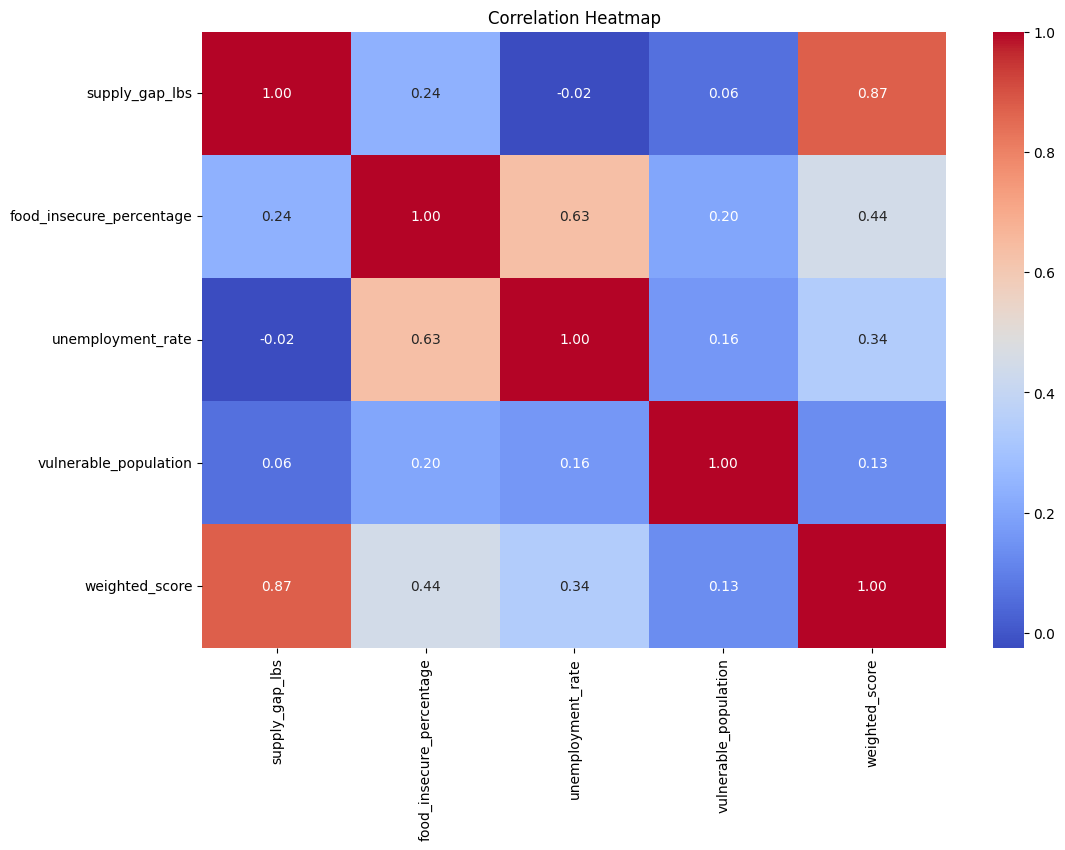

None
Correlation Matrix:
                          supply_gap_lbs  food_insecure_percentage  \
supply_gap_lbs                      1.00                      0.24   
food_insecure_percentage            0.24                      1.00   
unemployment_rate                  -0.02                      0.63   
vulnerable_population               0.06                      0.20   
weighted_score                      0.87                      0.44   

                          unemployment_rate  vulnerable_population  \
supply_gap_lbs                        -0.02                   0.06   
food_insecure_percentage               0.63                   0.20   
unemployment_rate                      1.00                   0.16   
vulnerable_population                  0.16                   1.00   
weighted_score                         0.34                   0.13   

                          weighted_score  
supply_gap_lbs                      0.87  
food_insecure_percentage            0.44  
unem

In [60]:
# correlation heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
correlation_matrix = df[["supply_gap_lbs", "food_insecure_percentage", "unemployment_rate", "vulnerable_population", "weighted_score"]].corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
print(plt.show())
print("Correlation Matrix:")
print(correlation_matrix)

#### Heatmap & Correlation Matrix Analysis
Based on the analysis, the most correlated variable with supply_gap_lbs is weighted_score (0.87), followed by food_insecure_percentage (0.24). Since weighted_score has the strongest correlation, we can plot a scatter plot between supply_gap_lbs and weighted_score. 

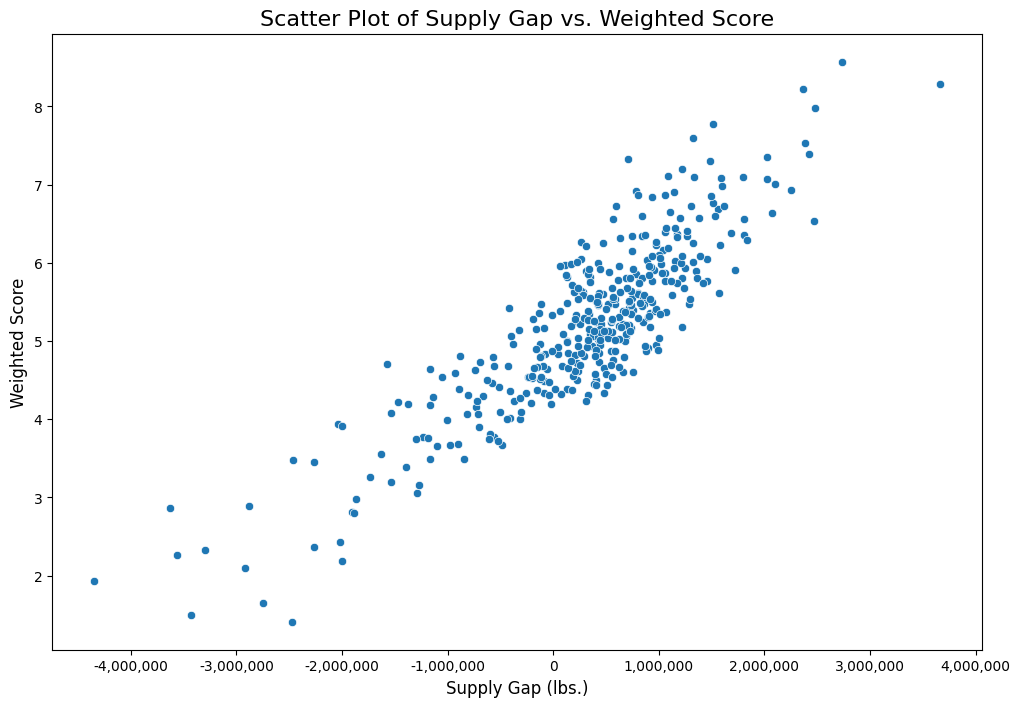

In [64]:
from matplotlib.ticker import FuncFormatter
# scatter plot for the most correlated variables (supply_gap_lbs & weighted_score)
plt.figure(figsize=(12, 8))
sns.scatterplot(x=df["supply_gap_lbs"], y=df["weighted_score"])

# labels and titles
plt.title("Scatter Plot of Supply Gap vs. Weighted Score", fontsize=16)
plt.xlabel("Supply Gap (lbs.)", fontsize=12)
plt.ylabel("Weighted Score", fontsize=12)

# formatting x-axis ticks to show full numbers with commas
formatter = FuncFormatter(lambda x, _: f'{int(x):,}')
plt.gca().xaxis.set_major_formatter(formatter)

plt.show()

## Modeling - Logistic Regression
---
[description here - look at jupyter notebook report example on canvas]
#### Model Development Steps
[describe here]



## Insights
---
[describe here]

## Conclusion
---
[describe here]
#### Key Takeaways:
- 
- 
- 

## Limitations
---
[describe here]

## Future Work
---


## References
---
